# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** What is TORCH.NN really?

</font>
</div>

In [ ]:
"""
PyTorch provides the elegantly designed modules and classes torch.nn , torch.optim , Dataset , and DataLoader 
to help you create and train neural networks.
"""

# Import modules

In [2]:
from pathlib import Path
import requests
import pickle
import gzip
from matplotlib import pyplot
import numpy as np
import torch
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Import MNIST dataset

In [3]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
"""
This dataset is in numpy array format, and has been stored using pickle, a python-specific format 
for serializing data.
"""

'\nThis dataset is in numpy array format, and has been stored using pickle, a python-specific format \nfor serializing data.\n'

In [5]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [6]:
"""
Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; 
we need to reshape it to 2d first.
"""

'\nEach image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; \nwe need to reshape it to 2d first.\n'

(50000, 784)


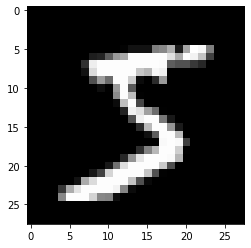

In [7]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

# From numpy to torch.tensor

In [8]:
"""
PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.
"""

'\nPyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.\n'

In [9]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

print(x_train)
print("")
print(y_train)
print("")
print(x_train.shape)
print("")
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([5, 0, 4,  ..., 8, 4, 8])

torch.Size([50000, 784])

tensor(0) tensor(9)


# Neural net from scratch (no torch.nn)

In [10]:
"""
PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and 
bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch 
that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it
can calculate the gradient during back-propagation automatically!
"""

'\nPyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and \nbias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch \nthat they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it\ncan calculate the gradient during back-propagation automatically!\n'

In [11]:
# weights initialised via Xavier initialisation
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [12]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    """
    X*W+b
    """
    return log_softmax(xb @ weights + bias)

In [13]:
"""
We will call our function on one batch of data (in this case, 64 images). This is one forward pass.
Note that our predictions won’t be any better than random at this stage, since we start with random weights.
"""

'\nWe will call our function on one batch of data (in this case, 64 images). This is one forward pass.\nNote that our predictions won’t be any better than random at this stage, since we start with random weights.\n'

In [14]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2952, -2.4086, -2.4515, -2.2214, -2.1909, -2.4676, -2.3802, -2.4418,
        -2.0633, -2.1936], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [15]:
"""
As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this
later to do backprop.
Let’s implement negative log-likelihood to use as the loss function.
"""

'\nAs you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this\nlater to do backprop.\nLet’s implement negative log-likelihood to use as the loss function.\n'

In [16]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [17]:
"""
Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.
"""

'\nLet’s check our loss with our random model, so we can see if we improve after a backprop pass later.\n'

In [18]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3081, grad_fn=<NegBackward>)


In [19]:
"""
Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index 
with the largest value matches the target value, then the prediction was correct.
"""

'\nLet’s also implement a function to calculate the accuracy of our model. For each prediction, if the index \nwith the largest value matches the target value, then the prediction was correct.\n'

In [20]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [21]:
"""
Let’s check the accuracy of our random model, so we can see if our accuracy improves as our loss improves.
"""

'\nLet’s check the accuracy of our random model, so we can see if our accuracy improves as our loss improves.\n'

In [22]:
print(accuracy(preds, yb))

tensor(0.1406)


In [23]:
"""
We can now run a training loop. For each iteration, we will:

    select a mini-batch of data (of size bs)
    use the model to make predictions
    calculate the loss
    loss.backward() updates the gradients of the model, in this case, weights and bias.

"""

'\nWe can now run a training loop. For each iteration, we will:\n\n    select a mini-batch of data (of size bs)\n    use the model to make predictions\n    calculate the loss\n    loss.backward() updates the gradients of the model, in this case, weights and bias.\n\n'

In [24]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [25]:
"""
That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we 
have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have
decreased and accuracy to have increased, and they have.
"""

'\nThat’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we \nhave no hidden layers) entirely from scratch!\n\nLet’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have\ndecreased and accuracy to have increased, and they have.\n'

In [26]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0847, grad_fn=<NegBackward>) tensor(1.)


# Using torch.nn.functional

In [27]:
"""
If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function 
F.cross_entropy that combines the two. So we can even remove the activation function from our model.
"""

'\nIf you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function \nF.cross_entropy that combines the two. So we can even remove the activation function from our model.\n'

In [28]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [29]:
"""
Note that we no longer call log_softmax in the model function. Let’s confirm that our loss and accuracy are 
the same as before:
"""

'\nNote that we no longer call log_softmax in the model function. Let’s confirm that our loss and accuracy are \nthe same as before:\n'

In [30]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0847, grad_fn=<NllLossBackward>) tensor(1.)


# Refactor using nn.Linear

In [31]:
"""
Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass 
nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a 
class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes 
and methods (such as .parameters() and .zero_grad()) which we will be using.
"""

'\nNext up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass \nnn.Module (which itself is a class and able to keep track of state). In this case, we want to create a \nclass that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes \nand methods (such as .parameters() and .zero_grad()) which we will be using.\n'

In [32]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [33]:
"""
Now we can calculate the loss in the same way as before. Note that nn.Module objects are used as if they 
are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method AUTOMATICALLY.
????
"""

'\nNow we can calculate the loss in the same way as before. Note that nn.Module objects are used as if they \nare functions (i.e they are callable), but behind the scenes Pytorch will call our forward method AUTOMATICALLY.\n????\n'

In [34]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.4392, grad_fn=<NllLossBackward>)


In [35]:
"""
OLD LENGHTLY WAY

with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
    
NEW SHORT WAY
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
"""

'\nOLD LENGHTLY WAY\n\nwith torch.no_grad():\n    weights -= weights.grad * lr\n    bias -= bias.grad * lr\n    weights.grad.zero_()\n    bias.grad.zero_()\n    \nNEW SHORT WAY\nwith torch.no_grad():\n    for p in model.parameters(): p -= p.grad * lr\n    model.zero_grad()\n'

In [36]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [37]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0810, grad_fn=<NllLossBackward>)


# Refactor using optim

In [38]:
"""
Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method 
from our optimizer to take a forward step, instead of manually updating each parameter. This will let us 
replace our previous manually coded optimization step.
"""

'\nPytorch also has a package with various optimization algorithms, torch.optim. We can use the step method \nfrom our optimizer to take a forward step, instead of manually updating each parameter. This will let us \nreplace our previous manually coded optimization step.\n'

In [39]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)


model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

tensor(2.2558, grad_fn=<NllLossBackward>)


In [40]:
print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


# Refactor using Dataset

In [41]:
"""
PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this 
also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make 
it easier to access both the independent and dependent variables in the same line as we train
"""

'\nPyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this \nalso gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make \nit easier to access both the independent and dependent variables in the same line as we train\n'

In [42]:
train_ds = TensorDataset(x_train, y_train)
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # dataset allows a much more compact syntax
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


# Refactor using DataLoader 

In [43]:
"""
Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. 
DataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i*bs : i*bs+bs], 
the DataLoader gives us each minibatch automatically.
"""

'\nPytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. \nDataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i*bs : i*bs+bs], \nthe DataLoader gives us each minibatch automatically.\n'

In [44]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0833, grad_fn=<NllLossBackward>)


# Add validation

In [45]:
"""
You shoudl alwasy have a vaidation to check for ovefitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other 
hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes
extra time, it makes no sense to shuffle the validation data.


We’ll use a batch size for the validation set that is twice as large as that for the training set. This is
because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store 
the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.
"""

'\nYou shoudl alwasy have a vaidation to check for ovefitting.\n\nShuffling the training data is important to prevent correlation between batches and overfitting. On the other \nhand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes\nextra time, it makes no sense to shuffle the validation data.\n\n\nWe’ll use a batch size for the validation set that is twice as large as that for the training set. This is\nbecause the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store \nthe gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.\n'

In [46]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [47]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3061)
1 tensor(0.3197)


# Create fit() and get_data()

In [ ]:
"""
We’ll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss 
for both the training set and the validation set, let’s make that into its own function, loss_batch, which computes 
the loss for one batch.

We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t 
pass an optimizer, so the method doesn’t perform backprop.
"""

In [49]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
"""
fit runs the necessary operations to train our model and compute the training and validation losses for each epoch.
"""

In [50]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [ ]:
"""
get_data returns dataloaders for the training and validation sets.
"""

In [51]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
"""
Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:
"""

In [52]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3004707724094391
1 0.29367565937042234


# Switch to CNN

In [ ]:
"""
We will use Pytorch’s predefined Conv2d class as our convolutional layer. We define a CNN with 3 convolutional 
layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling.
(Note that view is PyTorch’s version of numpy’s reshape)
"""

In [53]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


lr = 0.1

In [ ]:
"""
Momentum is a variation on stochastic gradient descent that takes previous updates into account as well and
generally leads to faster training.
"""

In [54]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36487024955749514
1 0.22502276515960692


# nn.Sequential

In [ ]:
"""
torch.nn has another handy class we can use to simply our code: Sequential . A Sequential object runs each of 
the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For 
instance, PyTorch doesn’t have a view layer, and we need to create one for our network. Lambda will create 
a layer that we can then use when defining a network with Sequential.
"""

In [55]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [56]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3382273998737335
1 0.25810160942077637


# Wrapping DataLoader

In [ ]:
"""

Our CNN is fairly concise, but it only works with MNIST, because:

        It assumes the input is a 28*28 long vector
        It assumes that the final CNN grid size is 4*4 (since that’s the average

pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, 
we can remove the initial Lambda layer but moving the data preprocessing into a generator:
"""

In [57]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
"""
Next, we can replace nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the 
output tensor we want, rather than the input tensor we have. As a result, our model will work with any 
size input.
"""

In [58]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [59]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3718876941204071
1 0.2833768991947174


# Using your GPU

In [60]:
print(torch.cuda.is_available())

False


In [ ]:
# create a device object for it
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
#Let’s update preprocess to move batches to the GPU:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
# Finally, we can move our model to the GPU.
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://pytorch.org/tutorials/beginner/nn_tutorial.html

</font>
</div>